In [0]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import keras
from skimage import data, img_as_float
from skimage import exposure
from skimage import io
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import rescale
import matplotlib.image as mpimg
from keras.models import load_model


from sklearn.utils import class_weight
import pandas as pd

Using TensorFlow backend.


In [4]:
pwd

'/content'

In [5]:
cd drive/My Drive/Unscript

/content/drive/My Drive/Unscript


In [6]:
cd ..

/content/drive/My Drive


In [0]:
DATASET_PATH = 'Unscript'

disease_cls = ['Actinic_Keratoses', 'Basal_cell_carcinoma', 'Benign_keratosis', 'Dermatofibroma', 'Melanoma',
               'Melanocytic_nevi', 'Vascular_skin_lesions', 'Normal_skin', 'Acne']

In [8]:
final_paths= list()
labels= dict()

for i, cls in enumerate(disease_cls):
    paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
    final_paths += paths
    labels.update({p:i for p in paths})
    
y_train= np.array(list(labels.values()))


# df= pd.read_csv("/home/nikhil/Desktop/Unscript_hackathon/HAM10000_metadata.csv")
# dx= np.array(df.dx)

# y_train= np.array(dx)

unique= np.unique(y_train)

print(y_train.shape)

weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights= dict()

for (key, value) in enumerate(weights):
    class_weights[key]= value

print(final_paths)
print(class_weights)
print(len(final_paths))

(7982,)
['Unscript/Actinic_Keratoses/101. torrance-actinic-keratosis-photos.jpg', 'Unscript/Actinic_Keratoses/103. 7c4d703c909d001f4aaa149f8bfae785.jpg', 'Unscript/Actinic_Keratoses/112. ak3-2.jpg', 'Unscript/Actinic_Keratoses/10. actinic-keratosis.jpg', 'Unscript/Actinic_Keratoses/102. annanda_chaga_case_study_actinic_keratosis_before_web_large.jpg', 'Unscript/Actinic_Keratoses/1. axbn7e.2e16d0ba.fill-920x613.jpg', 'Unscript/Actinic_Keratoses/108. actinic-keratosis-on-dorsal-hand-small-file.jpg', 'Unscript/Actinic_Keratoses/106. _e6_97_a5_e5_85_89_e6_80_a7_e8_a7_92_e5_8c_96_e7_97_87.jpg', 'Unscript/Actinic_Keratoses/109. actinic_keratosis_scope.jpg', 'Unscript/Actinic_Keratoses/111. solar-keratosis-1.jpg', 'Unscript/Actinic_Keratoses/105. ct097006415_fig1.jpg', 'Unscript/Actinic_Keratoses/128. images-1-300x150.jpeg', 'Unscript/Actinic_Keratoses/123. ca0219onlinefirstimage_1522994.jpg', 'Unscript/Actinic_Keratoses/122. ak03.jpg', 'Unscript/Actinic_Keratoses/129. solar-keratosis-brisban

In [9]:
len(labels)

7982

In [10]:
print("Keras File path:",keras.__file__)
print('Keras version:', keras.__version__)

Keras File path: /usr/local/lib/python3.6/dist-packages/keras/__init__.py
Keras version: 2.2.4


## Augmentations

In [0]:
# from imgaug import augmenters as iaa

# seq = iaa.Sequential([...])  # list of desired augmentors

# ig = ImageDataGenerator(preprocessing_function=seq.augment_image)  # pass this as the preprocessing function

# gen = ig.flow_from_directory(data_dir)  # nothing else changes with the generator

In [0]:
ablation = 2
list_IDs= list()
labels= dict()

for i, cls in enumerate(disease_cls):
    paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))

    if ablation is not None:
        paths = paths[:int(len(paths)*ablation/100)]

    list_IDs += paths
    labels.update({p:i for p in paths})

x_train= list()
img_rows, img_cols= 224, 224

def scale(img):
    img = (img - img.min())/(img.max() - img.min())
    return img

for path in list_IDs:
    img= mpimg.imread(path)
    img = scale(img)
    img= cv2.resize(img, (img_rows, img_cols))
    x_train.append(img)

print("x_train:", np.array(x_train).shape)
# x_train= np.array(x_train)

ValueError: could not broadcast input array from shape (224,224,3) into shape (224,224)

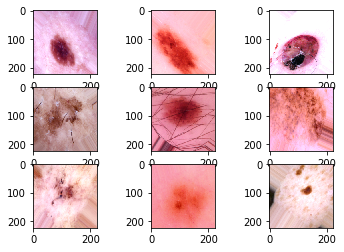

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    vertical_flip=True,
    horizontal_flip= True,
    brightness_range=[0.5, 1.5],
    zoom_range=0.2,
    shear_range= 0.2)


# fit parameters from data
datagen.fit(x_train)

# cv2.resize(image, (224,224), interpolation = inter)

# Configure batch size and retrieve one batch of images
for X_batch in datagen.flow(x_train, batch_size=9):    
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(scale(X_batch[i]))

    plt.show()
    break

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    vertical_flip=True,
    horizontal_flip= True,
    brightness_range=[0.5, 1.5],
    zoom_range=0.2,
    shear_range= 0.2)

___

## Resnet Model

In [0]:
import cv2
import numpy as np
import copy
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add, Dropout
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.engine import Layer, InputSpec
from keras import backend as K

## Import the Resnet Model

In [12]:
from keras.applications.mobilenet import MobileNet
model= MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling=None)

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
new_model=load_model('Unscript/models/best_model.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [48]:
index= 7500

val_img= mpimg.imread(final_paths[index])

val_img= preprocess_img(val_img, mode= 'val')


print(labels[final_paths[index]])
float(new_model.predict(val_img[np.newaxis, :])[0][7])

7


0.9587986469268799

In [17]:
float("8.993453535e-02")

0.08993453535

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

## Make all layers except the last 4 layers non-trainable

In [0]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [15]:
new_model = Sequential()
n_classes= len(disease_cls)

new_model.add(model)
 
# Add new layers
new_model.add(Flatten())
# new_model.add(Dense(32, activation='relu'))
# new_model.add(Dropout(0.5))
new_model.add(Dense(n_classes, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 451593    
Total params: 3,680,457
Trainable params: 1,502,217
Non-trainable params: 2,178,240
_________________________________________________________________


## Data Generator

In [0]:
img_rows= 224
img_cols= 224

params= {'theta': 45, 'tx': 0.2, 'flip_horizontal': True, 'flip_vertical': True}

def preprocess_img(img, mode):
    
    if mode == 'train':
      img = datagen.apply_transform(img, params)

      
#     print(type(img))
    
#     img= img[0,]
    
    
    print(img.shape)
    
    img= cv2.resize(img, (img_rows, img_cols))
    
    if(img.shape == (224, 224, 4)):
        img= img[:, :, :-1]

    elif(img.shape == (224, 224)):  
        img = np.stack((img,)*3, axis=-1)

    elif(img.shape == (224, 224, 1)):  
        img = np.stack((img,)*3, axis=-1)

    img = (img - img.min())/(img.max() - img.min())
    
    return img


#image= mpimg.imread("/home/nikhil/Desktop/Unscript_hackathon/HAM_10000/Normal_skin/2. best-foundations-black-skin.jpg")
#img= preprocess_img(image, mode= 'test')
#plt.imshow(img)
#print(img.shape)

def scale(img):
    img= (img - img.min())/(img.max() - img.min())
    return img

In [0]:
ran= np.random.rand(224, 224, 1)
ran_img= preprocess_img(ran, mode= 'test')
# plt.imshow(ran_img)
ran_img.shape

(224, 224, 3)

In [0]:
img= mpimg.imread("/home/nikhil/Desktop/Unscript_hackathon/HAM_10000/Acne/kdl.JPG")
img= preprocess_img(img, 'val')
img.shape

(224, 224, 3)

In [0]:
import numpy as np
import keras

augments= 2
BATCH_SIZE= 50 * augments

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = disease_cls, 
                 batch_size=BATCH_SIZE, dim=(224, 224), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.9)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})

        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / (self.batch_size//augments)))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        indexes = self.indexes[index * self.batch_size//augments: (index+1) * self.batch_size//augments]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
           
        for i, ID in enumerate(list_IDs_temp):
            img = mpimg.imread(ID)
            for j in range(augments):
                image = preprocess_img(img, self.mode)
                X[i*augments + j,] = image
                y[i*augments + j] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [0]:
training_generator = AugmentedDataGenerator('train', ablation= 5)
validation_generator = AugmentedDataGenerator('val', ablation= 5)

In [31]:
new_model.compile(loss= 'categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

new_model.fit_generator(generator=training_generator, validation_data=validation_generator, 
                        epochs=1, class_weight= class_weights)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
7/7 [==============================] - 27s 4s/step - loss: 4.4464 - acc: 0.0971


## ROC_AUC Callback

In [0]:
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

## Tensorboard Callback

Run this in terminal: <br/>
tensorboard --logdir path_to_current_dir/logs 

In [0]:
tb_callback= keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=BATCH_SIZE, write_graph=False)

In [20]:
pwd

'/content/drive/My Drive'

## Cyclical Learning Rate

In [0]:
from Unscript.CLR_master.clr_callback import *

clr_triangular = CyclicLR(mode='triangular', base_lr= 0.00001,max_lr= 0.0002, step_size= 800)

In [0]:
# plt.xlabel('Training Iterations')
# plt.ylabel('Learning Rate')
# plt.title("CLR - 'triangular' Policy")
# plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

## Model Checkpoint

In [23]:
'''checkpoint= keras.callbacks.ModelCheckpoint("best_model/model.hdf5", monitor='val_loss', verbose=0, 
                                save_best_only=True, mode='min', period=1)'''

'checkpoint= keras.callbacks.ModelCheckpoint("best_model/model.hdf5", monitor=\'val_loss\', verbose=0, \n                                save_best_only=True, mode=\'min\', period=1)'

In [32]:
#new_model.compile(loss='categorical_crossentropy' ,optimizer= 'RMSprop', metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train')
validation_generator = AugmentedDataGenerator('val')

auc_logger = roc_callback()
filepath = 'Unscript/models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

new_model.fit_generator(generator= training_generator,
                    validation_data= validation_generator,
                    epochs=200 , callbacks= [clr_triangular, auc_logger, checkpoint],
                    class_weight= class_weights)

Epoch 1/200
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(1200, 1600, 3)
(1200, 1600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(1200, 1600, 3)
(1200, 1600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(667, 1000, 3)
(667, 1000, 3)
(450, 600, 3)
(450, 600, 3)
(285, 380, 3)
(285, 380, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(112, 127, 3)
(112, 127, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(1200, 1600, 3)
(1200, 1600, 3)
(152, 94

AxisError: ignored

(450, 600, 3)


## Class Weights

In [0]:
disease_cls

['Actinic_Keratoses',
 'Basal_cell_carcinoma',
 'Benign_keratosis',
 'Dermatofibroma',
 'Melanoma',
 'Melanocytic_nevi',
 'Vascular_skin_lesions',
 'Normal_skin',
 'Acne']

{0: 2.116675096948238, 1: 1.5228044638524987, 2: 1.0020753512132823, 3: 4.078622482131254, 4: 1.0013559862806094, 5: 0.2023044073805495, 6: 4.414205344585091, 7: 3.558390022675737, 8: 5.601963409192325}
